In [1]:
# import libaries
import geopandas as gpd
import pandas as pd
import json
import numpy as np
from sqlalchemy import create_engine
import time
from datetime import date, timedelta
from rl_v2g import CarsharingEnv
import math

# load the database credentials from the JSON file
with open('config/credentials.json') as f:
    credentials = json.load(f)

# create connection string
connection_string = f"postgresql://{credentials['username']}:{credentials['password']}@{credentials['host']}:{credentials['port']}/{credentials['database_name']}"

# create the engine with the connection string
engine = create_engine(connection_string)


C:\Users\domin\anaconda3\envs\simulation_car_sharing\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Imports for V2G optimisation
import matplotlib.pyplot as plt
from datetime import datetime

# Constant values used for the simulation

In [3]:
# Elie's cell
Number_of_days_sim = 2

# Price
price_low = 0.05
price_high = 0.08
cheapest_price_percentage = 20

print("Price low : {} CHF/kWh".format(price_low))
print("Price high : {} CHF/kWh".format(price_high))




Price low : 0.05 CHF/kWh
Price high : 0.08 CHF/kWh


# Application of Car-sharing Simulation Environment 

Choose the timespan for the simulation. The simulation will be executed chronologically, starting from the first day (2019-1-1) and continuing for subsequent days (2019-1-2, 2019-1-3, etc.). If a start date other than 2019-1-1 is selected, the "Start simulation" cell below may need to be modified.

In [4]:
# set simulation period
start_date = date(2019, 1, 1)

# end_date = date(2019, 1, 8) # Original
# print("Original end_date : {} \t {}".format(end_date, type(end_date)))
end_date = start_date + timedelta(days = (Number_of_days_sim -1))
print("Original end_date : {} \t {}".format(end_date, type(end_date)))

# calculate number of days to simulate
nr_iterations = (end_date - start_date).days
print("Simulation during {} days".format(nr_iterations + 1))

Original end_date : 2019-01-02 	 <class 'datetime.date'>
Simulation during 2 days


# Load data for simulation

### Car-sharing stations

In [5]:
# get station geodata, create spatial index
sql = " SELECT * FROM msc_2023_dominik.distinct_stations"
stations = gpd.read_postgis(sql, engine, geom_col='geom',crs = "EPSG:2056")
stations.sindex
# stations.head()

### Vehicle information

In [6]:
# get vehicle data
sql = "SELECT * FROM msc_2023_dominik.vehicle_information ORDER BY vehicle_no"
vehicles = pd.read_sql(sql, engine)
# vehicles.head()

### Reservations

In [7]:
# Elie Cell
# Create a pd.DataFrame for weekly reservations
reservations_week = pd.DataFrame()
i = 1

In [8]:
# get daily reservations, save in dict for fast data access
delta = timedelta(days=1)
reservations_dict = {}
start_date_reservations = start_date
while start_date_reservations <= end_date:
    sql = """SELECT reservation_no, start_station_no, vehicle_no, reservationfrom_time_discrete, drive_firststart_time_discrete, 
            drive_lastend_time_discrete, reservation_duration, revenue_distance, required_soc, revenue_duration, drive_km, 
            (floor(EXTRACT(epoch FROM (date_trunc('hour', TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) + 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_lastend, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes' 
                                - date_trunc('hour', TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) - 
                                floor(EXTRACT(minute FROM TO_TIMESTAMP(drive_firststart, 'YYYY-MM-DD HH24:MI:SS.MS')) / 15) * interval '15 minutes'
                               )) / 900) * 900 + 900) / 900 AS drive_duration
            FROM msc_2023_dominik.reservations_long_time 
            WHERE  DATE(reservationfrom_discrete_date) = '{}' or  DATE(drive_firststart_discrete_date) = '{}' 
            ORDER BY reservationfrom_discrete""".format(start_date_reservations, start_date_reservations)
    reservations = pd.read_sql(sql, engine)
    reservations_dict[start_date_reservations.strftime('%Y-%m-%d')] = reservations
    start_date_reservations += delta
    
    #--------------------------------------------------------------------------Start
    # Add the Bookings of current day to the reservations of the week
    reservations_week = pd.concat([reservations_week, reservations])
    print("Reservations on days {} : {}".format(i, reservations_week.shape))
    i = i + 1
    # -------------------------------------------------------------------------End
    
# reservations_dict[(start_date).strftime('%Y-%m-%d')].head()

Reservations on days 1 : (1617, 12)
Reservations on days 2 : (4130, 12)


In [9]:
# Add index to the -table to speedup the search in this table

#### Add column "step_from_1jan19" to "reservations_week" (added for V2G)
This will help to find the next booking faster

In [10]:
# # Create 1jan19 (01.01.2019 at 00:00)
# d = '2019-01-01 00:00'
# firstJan19 =  datetime.strptime(d, '%Y-%m-%d %H:%M')
# # print("First January 2019 : {}".format(firstJan19))
# 
# # Convert "reservationfrom" column into datetime object
# reservations_week["reservationfrom"] = pd.to_datetime(reservations_week["reservationfrom"])
# 
# # Calculate the number of steps from 1 jan 2019
# reservations_week["steps_from_1jan19"] = (reservations_week["reservationfrom"] - firstJan19)/pd.Timedelta('900s')
# # reservations_week[["steps_from_1jan19", "reservationfrom"]]
# 
# print("step_from_1jan19 column has been created sucessfully !")


# reservations_week

### Replace NaN from drive_km column by 1 km

In [11]:
reservations_week.loc[reservations_week['drive_km'].isnull(), 'drive_km'] = 1
reservations_week[reservations_week['drive_km'].isnull()]

,reservation_no,start_station_no,vehicle_no,reservationfrom_time_discrete,drive_firststart_time_discrete,drive_lastend_time_discrete,reservation_duration,revenue_distance,required_soc,revenue_duration,drive_km,drive_duration


In [12]:
reservations_week

,reservation_no,start_station_no,vehicle_no,reservationfrom_time_discrete,drive_firststart_time_discrete,drive_lastend_time_discrete,reservation_duration,revenue_distance,required_soc,revenue_duration,drive_km,drive_duration
0,24519192,2886,114874,0.0,0.0,4.0,6.0,10.50,5.384615,5.25,14.0,4.0
1,24519174,1557,115969,0.0,0.0,49.0,50.0,45.75,30.500000,43.75,61.0,50.0
2,24514447,2702,114871,0.0,4.0,5.0,6.0,2.66,1.538462,7.50,4.0,2.0
3,24519221,3165,116525,0.0,0.0,96.0,96.0,0.00,0.000000,0.00,0.0,97.0
4,24519097,4407,113833,0.0,2.0,9.0,10.0,13.00,10.000000,6.25,20.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2508,24524978,1819,115444,188.0,188.0,191.0,4.0,4.55,3.500000,2.50,7.0,4.0
2509,24138605,4343,116426,188.0,189.0,208.0,22.0,35.20,10.476190,16.50,44.0,21.0
2510,24525296,2121,119572,190.0,190.0,96.0,4.0,11.05,8.500000,2.50,17.0,3.0
2511,24525342,3773,116220,190.0,96.0,200.0,14.0,12.00,8.000000,12.25,16.0,10.0


### Electicity prices for charging

In [13]:
# get charging costs data
prices = ""
for i in range(0, 480, 5):
    price = i / 20
    prices += '"Price_chf_kwh_{}", '.format(price)

sql = """SELECT {} "Delivery day" FROM msc_2023_dominik.charging_costs WHERE "Delivery day" >=  '{}' and "Delivery day" <=  '{}' ORDER BY "Delivery day" """.format(prices, start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))

charging_costs = pd.read_sql(sql, engine)
charging_costs.head()

,Price_chf_kwh_0.0,Price_chf_kwh_0.25,Price_chf_kwh_0.5,Price_chf_kwh_0.75,Price_chf_kwh_1.0,Price_chf_kwh_1.25,Price_chf_kwh_1.5,Price_chf_kwh_1.75,Price_chf_kwh_2.0,Price_chf_kwh_2.25,...,Price_chf_kwh_21.75,Price_chf_kwh_22.0,Price_chf_kwh_22.25,Price_chf_kwh_22.5,Price_chf_kwh_22.75,Price_chf_kwh_23.0,Price_chf_kwh_23.25,Price_chf_kwh_23.5,Price_chf_kwh_23.75,Delivery day
0,0.054160,0.054160,0.054160,0.054160,0.052522,0.052522,0.052522,0.052522,0.050906,0.050906,...,0.054634,0.059397,0.059397,0.059397,0.059397,0.059387,0.059387,0.059387,0.059387,2019-01-01
1,0.053848,0.053848,0.053848,0.053848,0.052436,0.052436,0.052436,0.052436,0.044785,0.044785,...,0.065669,0.064731,0.064731,0.064731,0.064731,0.063546,0.063546,0.063546,0.063546,2019-01-02


In [14]:
# save in dict for fast data access
delta = timedelta(days=1)
charging_costs_dict = {}
start_date_electricity = start_date
while start_date_electricity <= end_date:
    electricity_price_day = charging_costs[charging_costs["Delivery day"].dt.date == start_date_electricity].drop(["Delivery day"],axis = 1).iloc[0].values
    charging_costs_dict[start_date_electricity.strftime('%Y-%m-%d')] = electricity_price_day
    start_date_electricity += delta

### Secondary energy prices (for V2G)

In [15]:
# get v2g price data
sql = """SELECT "Timestamp", "Secondary_positive_v2g_prices_chf_kwh", "Secondary_negative_v2g_prices_chf_kwh" FROM msc_2023_dominik.v2g_prices WHERE "Timestamp" >=  '{}' and "Timestamp" <=  '{}' ORDER BY "Timestamp" """.format(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
v2g_prices = pd.read_sql(sql, engine)
v2g_prices.head()

,Timestamp,Secondary_positive_v2g_prices_chf_kwh,Secondary_negative_v2g_prices_chf_kwh
0,2019-01-01 00:00:00,0.068370,0.045588
1,2019-01-01 00:15:00,0.068838,0.045896
2,2019-01-01 00:30:00,0.068838,0.045896
3,2019-01-01 00:45:00,0.068838,0.045896
4,2019-01-01 01:00:00,0.068838,0.045896


In [16]:
# save in dict for fast data access
delta = timedelta(days=1)
v2g_price_dict = {}
start_date_v2g = start_date
while start_date_v2g <= end_date:
    v2g_price_day_positive = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_positive_v2g_prices_chf_kwh"].values
    v2g_price_day_negative = v2g_prices[v2g_prices['Timestamp'].dt.date == pd.Timestamp(start_date_v2g).date()].drop(["Timestamp"],axis = 1)["Secondary_negative_v2g_prices_chf_kwh"].values
    v2g_price_dict[start_date_v2g.strftime('%Y-%m-%d')] = [v2g_price_day_positive, v2g_price_day_negative]
    start_date_v2g += delta

# Create environment

The following code creates the simulation enviroment. The list below descripes all parameters that can be specified. You can experiment and change the default values for costs, penalties, probabilities and time periods of V2G events, etc.

**stations:** Geopandas Geodataframe<br>
*Locations of car-sharing stations, including a distinct "station_no" attribute with station ID.*

**vehicle_information:** Pandas Dataframe<br>
*Includes the features "vehicle_no", "charge_power", "battery_capacity", and "vehicle_category" for each car.*

**soc_initial_low:** float, optional<br>
*Lower bound (0-1) for initial SOC used for the reset of the environment, by default 0.5.*

**doc_initial_high:** float, optional<br>
*Upper bound (0-1) for initial SOC used for the reset of the environment, by default 1.*

**max_charging_power:** int, optional<br>
*Maximum charging power supported by the infrastructure, by default 11kw.*

**episode_len:** int, optional<br>
*Length of one episode in hours, by default 24.*

**dt:** float, optional<br>
*Time step size in hours, by default 0.25 (a quarter hour).*

**cancellation_penalty:** int, optional<br>
*Maximum penalty in CHF for a booking cancelled due to not enough charged battery, by default 100.*

**last_timestep:** int, optional<br>
*Last timestep of simulation, by defualt 55392.*

**random_seed_number:** int, optional<br>
*Used for fixing random components in environment for reproducable results, by default 42.*

**penalty_per_kwh:** int, optional<br>
*Penalty in CHF/kWh for total negative energy difference between beginning and ending of episode, by default 0.25.*

**v2g:** boolean, optional<br>
*Boolean indicating if V2G events take place, by default True.*

**v2g_demand_event_min:** int, optional<br>
*Minimum energy demand during V2G event in kWh per time step (dt), by default 500.*

**v2g_demand_event_max:** int, optional<br>
*Maxiumunm energy demand during V2G event in kwh per time step (dt), by default 500.*

**v2g_max_duration:** int, optional<br>
*Maximum duration of V2G charging or discharging event in hours, by default 3.*

**V2G_penalty:** int, optional<br>
*Penalty in CHF if agent charges/discharges less energy than specified in "v2g_demand_event" during V2G event, by default 10000.*

**v2g_probability_charging_event:** float, optional<br>
*Probability that a charging event will take place around noon, by default 0.5.*

**v2g_probability_discharging_event:** float, optional<br>
*Probability that a discharging event will take place in the morning or evening, by default 0.5.*

**v2g_morning_time_period:** list, optional<br>
*Time period must end before noon. List containing:*
1. first possible time (hours) for starting v2g discharging event in the morning, by default 6.0 (6 AM).
2. last possible time (hours) for starting v2g discharging event in the morning, by default 9.0 (9 AM).
3. last possible timestamp for v2g discharging operation, by default 10.75 (10:45 AM).
                        
**v2g_noon_time_period:** list, optional<br>
*List containing:* 
1. first possible time (hours) for starting v2g charging event at noon, by default 11.0 (11 AM).
2. last possible time (hours) for starting v2g charging event at noon, by default 14.0 (2 PM).
3. last possible timestamp for v2g charging operation, by default 16.0 (4 PM).
                             
**v2g_evening_time_period:** list, optional<br>
*Time period must start after noon. List containing:*
1. first possible time (hours) for starting v2g discharging event in the evening, by default 16.25 (4:15 PM).
2. last possible time (hours) for starting v2g discharging event in the evening, by default 19.0 (7 PM).
3. last possible timestamp for v2g charging operation, by default 24 (00:00 AM, next day).
                             
**planned_bookings:** boolean, optional<br>
*Boolean indicating whether there are planned bookings in the environment; otherwise, all bookings are spontaneous, by default True.*

**precomputed_bookings:** boolean, optional<br>
*Boolean indicating whether the planned bookings in the environment are precomputed (for massive speed up), by default True.*

**max_distance_car_assingment:** int, optional<br>
*Maximum search distance in meter for car-assingment problem, by default 5000.*

**plot_state_histogram:** boolean, optional<br>
*Plot current state of enviorment as histogram or not, by default True.*

**plot_state_animation:** boolean, optional<br>
*Plot current state of enviorment as animation for each car or not, by default True.*

In [17]:
# create environment
# env = CarsharingEnv(stations, vehicles, planned_bookings = False, v2g_penalty = 10000, penalty_per_kwh = 0) # Original

# !!!!!!!!!!!!!!!!!!!!!!!!! No more v2g_reward !!!!!!!!!!!!!!!!!!!!!!!!!

env = CarsharingEnv(stations,
                    vehicles,
                    cancellation_penalty = 100,
                    penalty_per_kwh = 0, # penalty for energy difference between start and end of the day
                    planned_bookings = False,
                    max_distance_car_assingment = 1000,
                    v2g_morning_time_period = [6.0, 6.5, 8.0], # Discharging vehicle event
                    v2g_evening_time_period = [18.0, 18.5, 20.0], # Discharging vehicle event
                    v2g_probability_discharging_event = 1.0,
                    v2g_noon_time_period = [12.0, 12.0, 14.0], # Charging vehicle event
                    v2g_probability_charging_event = 0.0,
                    v2g_penalty = 499,
                    # random_seed_number = 42
                    )

TypeError: __init__() missing 4 required positional arguments: 'daily_data', 'reservations', 'electricity_price', and 'timesteps_since_start'

# Functions used for V2G optimization

In [18]:
# Change Pandas settings, so that every column is displayed
pd.set_option('display.max_columns', None)

## Everything related to the price of electricity

In [19]:
# Get Electricity price
# print("Type of charging_costs : {}".format(type(charging_costs)))

# Create a 1d array with the price of electricity
electricity_price_pd = charging_costs.copy()
# print("Type of electricity_price_pd : {}".format(type(electricity_price_pd)))
electricity_price_pd = electricity_price_pd.drop(columns=['Delivery day'])
# print("Type of electricity_price_pd : {}".format(type(electricity_price_pd)))
electricity_price = electricity_price_pd.values.reshape(-1)

    
# Find min and max electricity price
max_price = max(electricity_price)
min_price = min(electricity_price)

print("Max electricity price : {} CHF/kWh".format(max_price))
print("Min electricity price : {} CHF/kWh".format(min_price))

Max electricity price : 0.07556131199999999 CHF/kWh
Min electricity price : 0.028922783999999997 CHF/kWh


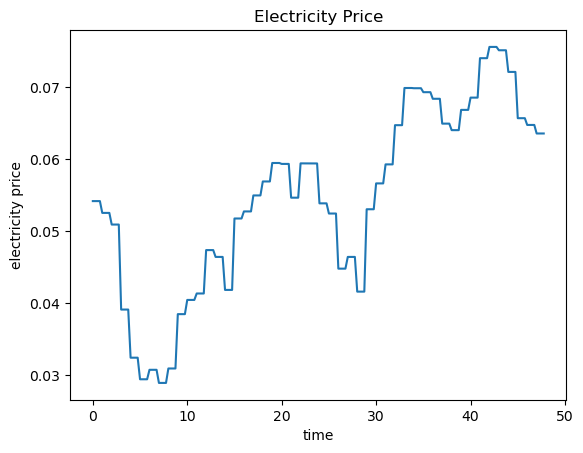

In [20]:
# Plot the electricity price
time_float = []
last_i = 0
for i in range(96*Number_of_days_sim):
    time_float.append(i/4)
    last_i = i
    
# print("Last_i : {}".format(last_i))

label_x_axis = "time"
label_y_axis = "electricity price"
title_plot = "Electricity Price".format()
filename_plot = "electricity_price.png".format()

x = time_float
y = electricity_price

fig, ax = plt.subplots()
# ax.scatter(x, y)
plt.plot(x,y)

plt.xlabel(label_x_axis)
plt.ylabel(label_y_axis)
plt.title(title_plot) 

plt.savefig(filename_plot)

In [21]:
# print(charging_costs_list)
print("Number of elements in the electricity_price : {}".format(len(electricity_price)))
print("Expected elements = {}".format(4*24*Number_of_days_sim))
print("dim of charging_costs : {}".format(charging_costs.shape))

Number of elements in the electricity_price : 192
Expected elements = 192
dim of charging_costs : (2, 97)


In [22]:
# TODO

# Read the price of last month

# Calculate min and max values out of mean(min or max of each day)

## Functions related to the bookings

### Function that finds the next booking of a given vehicle
Inputs :
* vehicle_no
* current_time (as datetime_object)
* bookings of current week

Outputs :
* dist_next_booking
* steps_until_next_booking

In [23]:
def next_booking_one_vehicle(cur_vehicle_nr, cur_time, booking_list):
    
    # print("veh_nr_list len : {} \ttype : {}".format(len(veh_nr_list), type(veh_nr_list)))    
    # print("veh_nr_list first elt : {}\tlast element : {}\n".format(veh_nr_list[0], veh_nr_list[len(veh_nr_list)-1]))
    
    # Create 1jan19 (01.01.2019 at 00:00)
    d = '2019-01-01 00:00'
    firstJan19 =  datetime.strptime(d, '%Y-%m-%d %H:%M')
    # print("First January 2019 : {}".format(firstJan19))
    
    # Calculate current step
    current_steps_from_1jan19 = (cur_time - firstJan19).total_seconds() // 900
    # print("Steps from 1jan19 : {}\n".format(current_steps_from_1jan19))
    
    # Load all the bookings of current vehicle
    reservation_current_vehicle = booking_list[booking_list['vehicle_no'] == cur_vehicle_nr]
    # Keep only bookings that starts after current step
    reservation_current_vehicle_future = reservation_current_vehicle[reservation_current_vehicle['reservationfrom_time_discrete'] > current_steps_from_1jan19]
    
    # Prepare variables for the output of this vehicle_nr (default = -1)
    steps_until_next_booking = -1
    dist_next_booking = -1
    
    # Check it the current_vehicle is booked this week (if the booking_table of this vehicle is not empty)
    if reservation_current_vehicle_future.shape[0] > 0 : # There are still reservations this week for this vehicle
        
        # Find the next future booking in the bookin list
        next_reservation = reservation_current_vehicle_future.sort_values("reservationfrom_time_discrete").iloc[0]
    
        # Calculate the number of steps until next booking
        next_step = next_reservation['reservationfrom_time_discrete']
        steps_until_next_booking = next_step - current_steps_from_1jan19
        # Extract the distance of the next booking
        dist_next_booking = next_reservation['drive_km']
    
    # If there is no more reservation for the current vehicle in this week
    else:
        info = "here we do nothing"
        # print("No reservation for vehicle {}".format(cur_vehicle_nr))
    
    
    # print("Number of steps until next reservation : {}".format(steps_until_next_booking))
    # print("Distance of next trip : {}\t{}".format(dist_next_booking, type(dist_next_booking)))
    
    # print("\n-----------------------------------\n")
    
    # print("lenght of lists = {} & {}".format(len(steps_until_next_booking_list), len(dist_next_booking_list)))
    
    return steps_until_next_booking, dist_next_booking

### Function that initialize the informations for each vehicle
Inputs:
* vehicle_no (list)
* vehicle_range (list)
* current_time (datetimeObject)
* bookings of current week

Output:
* steps until next booking (-1 if no more reservation this week)
* km of next booking (-1 if no more reservation this week)

This function is used at the begining of the simulation to assign to each vehicle it's next booking distance and step

In [24]:
# Reworked version
def vehicle_stat_v2g_initialization(veh_nr_list, veh_range_list, veh_charg_power_list, veh_bat_capacity_list, cur_time, booking_list):
    
    # Number of vehicles
    n = len(veh_nr_list)
    
    listofzeros = [0] * n
    
    print("Number of vehicles in the simulation : {}".format(n))
    
    
    # Create lists for the next booking
    steps_until_next_booking_list = []
    dist_next_booking_list = []
    soc_next_booking_list = []
    
    # For each vehicle find the next booking (loop over each vehicle_nr)
    i = 0
    for cur_vehicle_nr in veh_nr_list:
        
        # for each vehicle calculate the distance and the number of steps until next booking
        number_steps, next_distance = next_booking_one_vehicle(cur_vehicle_nr, cur_time, booking_list)
        
        # Calculate soc_next_booking
        soc_next_booking = max(next_distance / veh_range_list[i], 0) # TO avoid negative soc_next_booking
        
        # Add the number of steps and the distance of the next booking to the lists to export
        steps_until_next_booking_list.append(number_steps)
        dist_next_booking_list.append(next_distance)
        soc_next_booking_list.append(soc_next_booking)
    
    
    
    print("number of elements in the soc_next_booking : {}".format(n))
    
    energy_per_step_list = veh_charg_power_list / 4.0
    
    # Preparation for the output
    outputDict = {'vehicle_no':veh_nr_list,
                  'range':veh_range_list,
                  'charge_power':veh_charg_power_list,
                  'energy_per_step':energy_per_step_list,
                  'battery_capacity':veh_bat_capacity_list,
                  'soc_this_step':listofzeros,
                  'vehicle_location':listofzeros,
                  'steps_until_next_booking':steps_until_next_booking_list,
                  'dist_next_booking':dist_next_booking_list,
                  'soc_next_booking':soc_next_booking_list,
                  'dSoC_next_booking':listofzeros,
                  'v2g_margin_steps':listofzeros,
                  'v2g_deliverable_steps':listofzeros,
                  'v2g_candidat':listofzeros,
                  'v2g_ready':listofzeros,
                  'v2g_assigned':listofzeros,
                  'smart_charging_this_step':listofzeros,
                  'action_this_step':listofzeros,
                  'dummy':listofzeros
                 }
    
    outputPD = pd.DataFrame.from_dict(outputDict)
    
    return outputPD

In [25]:
# Test if the function works

# datetime from the 01.01.2019 00:00
d = '2019-01-01 00:00'
firstJan19 =  datetime.strptime(d, '%Y-%m-%d %H:%M')

next_bookings_pandas =  vehicle_stat_v2g_initialization(vehicles['vehicle_no'], vehicles['range'], vehicles['charge_power'], vehicles['battery_capacity'], firstJan19, reservations_week)

Number of vehicles in the simulation : 4420
number of elements in the soc_next_booking : 4420


In [26]:
reservations_week

,reservation_no,start_station_no,vehicle_no,reservationfrom_time_discrete,drive_firststart_time_discrete,drive_lastend_time_discrete,reservation_duration,revenue_distance,required_soc,revenue_duration,drive_km,drive_duration
0,24519192,2886,114874,0.0,0.0,4.0,6.0,10.50,5.384615,5.25,14.0,4.0
1,24519174,1557,115969,0.0,0.0,49.0,50.0,45.75,30.500000,43.75,61.0,50.0
2,24514447,2702,114871,0.0,4.0,5.0,6.0,2.66,1.538462,7.50,4.0,2.0
3,24519221,3165,116525,0.0,0.0,96.0,96.0,0.00,0.000000,0.00,0.0,97.0
4,24519097,4407,113833,0.0,2.0,9.0,10.0,13.00,10.000000,6.25,20.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2508,24524978,1819,115444,188.0,188.0,191.0,4.0,4.55,3.500000,2.50,7.0,4.0
2509,24138605,4343,116426,188.0,189.0,208.0,22.0,35.20,10.476190,16.50,44.0,21.0
2510,24525296,2121,119572,190.0,190.0,96.0,4.0,11.05,8.500000,2.50,17.0,3.0
2511,24525342,3773,116220,190.0,96.0,200.0,14.0,12.00,8.000000,12.25,16.0,10.0


In [27]:
vehicles

,index,vehicle_category,vehicle_no,model_name,brand_name,charge_power,battery_capacity,range
0,2962,Minivan,106516,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
1,2963,Minivan,106517,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
2,2964,Minivan,106518,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
3,2965,Minivan,106519,eVito 129KB Tourer Pro 3200,Mercedes-Benz,11.0,100.0,378.0
4,2966,Combi,106526,Enyaq iV80,Skoda,11.0,82.0,420.0
...,...,...,...,...,...,...,...,...
4415,2957,Combi,130999,Enyaq iV80,Skoda,11.0,82.0,420.0
4416,2958,Combi,131000,Enyaq iV80,Skoda,11.0,82.0,420.0
4417,2959,Combi,131001,Enyaq iV80,Skoda,11.0,82.0,420.0
4418,2960,Emotion,131927,Tesla Model 3,Tesla,11.0,75.0,499.0


### Function that update the next booking for each vehicle
This help to speedup the smart charging. Only when a booking is at current time, the next one is searched. In this way each booking is search only one time during the simulation.

In [28]:
# Reworked version
def update_next_bookings(cur_time, veh_state_v2g, booking_list):
    
    veh_nr_list = veh_state_v2g['vehicle_no'].values.tolist()
    next_steps_list = veh_state_v2g['steps_until_next_booking'].values.tolist()
    km_next_list = veh_state_v2g['dist_next_booking'].values.tolist()
    
    veh_range_list = veh_state_v2g['range'].values.tolist()
    soc_n_booking_list = veh_state_v2g['soc_next_booking'].values.tolist()
    
    researched_bookings = 0
    updated_elts = 0
    
    for i in range(len(veh_nr_list)):
        
        if next_steps_list[i] == 0: # or 1, have to think about it
            # search for next booking
            cur_veh_nr = veh_nr_list[i]
            cur_next_steps, cur_km_next = next_booking_one_vehicle(cur_veh_nr, cur_time, booking_list)
            
            next_steps_list[i] = cur_next_steps
            km_next_list[i] = cur_km_next
            
            soc_n_booking_list[i] = max(cur_km_next / veh_range_list[i], 0)
            
            researched_bookings = researched_bookings + 1
            
        else:
            next_steps_list[i] = next_steps_list[i] - 1
            updated_elts = updated_elts + 1
    
        
    
    veh_state_v2g['steps_until_next_booking'] = next_steps_list
    veh_state_v2g['dist_next_booking'] = km_next_list
    veh_state_v2g['soc_next_booking'] = soc_n_booking_list
    
    # print("number of searched bookings : {}".format(researched_bookings))
    # print("number of updated elements : {}".format(updated_elts))
    
    return veh_state_v2g

In [29]:
# Test if the function works (uncomment the 2 last lines to check)
d = '2019-01-01 06:15'
time_now =  datetime.strptime(d, '%Y-%m-%d %H:%M')
next_bookings_pandas = update_next_bookings(time_now, next_bookings_pandas, reservations_week)
# next_bookings_pandas[next_bookings_pandas['steps_until_next_booking']>=0]

In [30]:
# next_bookings_pandas[next_bookings_pandas['steps_until_next_booking']==2]

next_bookings_pandas[next_bookings_pandas['vehicle_no']==113941]

,vehicle_no,range,charge_power,energy_per_step,battery_capacity,soc_this_step,vehicle_location,steps_until_next_booking,dist_next_booking,soc_next_booking,dSoC_next_booking,v2g_margin_steps,v2g_deliverable_steps,v2g_candidat,v2g_ready,v2g_assigned,smart_charging_this_step,action_this_step,dummy
334,113941,420.0,11.0,2.75,82.0,0,0,3.0,10.0,0.026455,0,0,0,0,0,0,0,0,0


# Display the parameters used for the simulation

In [31]:
# Display the parameters used for the simulation

# Price : min, max, low tolerance
print("Max electricity price : {} CHF/kWh".format(max_price))
print("Min electricity price : {} CHF/kWh".format(min_price))
print("Cheapest price percentage : {} %".format(cheapest_price_percentage))
print("\n")
print("Price low : {} CHF/kWh".format(price_low))
print("Price high : {} CHF/kWh".format(price_high))

Max electricity price : 0.07556131199999999 CHF/kWh
Min electricity price : 0.028922783999999997 CHF/kWh
Cheapest price percentage : 20 %


Price low : 0.05 CHF/kWh
Price high : 0.08 CHF/kWh


In [32]:
price_min = 0.05
price_max = 0.08
cheapest_price_percentage = 20
price_limit_sm = price_min + (cheapest_price_percentage/100) * (price_max - price_min)
print("price_limit_sm : {} CHF/kWh".format(price_limit_sm))

price_limit_sm : 0.056 CHF/kWh


# Implement your charging strategy

In [33]:
# def your_v2g_strategy(state, nr_vehicles):
def your_v2g_strategy(state, nr_vehicles, vehicle_range, vehicle_nr, count, vehicles_info, bookings, cur_time, vehicle_state_v2g, cur_el_price):

    print("\n")
    print("\n")
    
    # Variables for the whole function
    price_min = 0.05
    price_max = 0.08
    cheapest_price_percentage = 20
    price_limit_sm = price_min + (cheapest_price_percentage/100) * (price_max - price_min)
    print("Electricity Price : {} \t price_limit_sm : {} CHF/kWh".format(cur_el_price, price_limit_sm))
    
    energy_to_deliver_per_step = 500 # in kWh
    v2g_steps_threshold = 6 # = discharging during 1.5 hours possible
    
    #////////////////////////////////// Read current state ///////////////////////////////////
    
    # cur_el_price = electricity_price(cur_step_from_1jan)
    
    # state has length of nr_vehicles * 4 + 2  
    print("Lenght that state currently has : {}".format(len(state)))
    print("Length that state should have : {}".format(nr_vehicles*2 + 2))
    
    # get current locations of vehicles (station number integer between 1000 and 5000, reservation number integer between 20000000 and 40000000, or -1 if vehicle not aviable/not implemented in system)
    locations_of_vehicles = state[:nr_vehicles]
        
    # get current SOC of vehicles (float between 0 and 1)
    soc_of_vehicles = state[nr_vehicles:nr_vehicles * 2]
    
    # get planned reservations of vehicles, integer between 0 and 55392
    # planned_reservations = state[nr_vehicles * 2:nr_vehicles * 3]
    
    # get durations of planned reservations of vehicles, integer between 0 and 55392
    # planned_reservations = state[nr_vehicles * 3:nr_vehicles * 4]
        
    # check if V2G event will take place and get demand in the next timestep (0 = no V2G event, positive integer between 500 and 1000 = discharging event, negative integer between 500 and 1000 = charging event)
    v2g_event = state[nr_vehicles * 2:nr_vehicles * 2 + 1]
    # print(("Lenght of v2g_event : {}".format(len(v2g_event))))
    # print(("Type of v2g_event : {}".format(type(v2g_event))))
    print("V2g_event : {}\t len : {}\t type : {}".format(v2g_event, len(v2g_event), type(v2g_event)))
    
    # get current simulation time, integer between 0 and 55392
    current_time = state[nr_vehicles * 2 + 1:]
    # print(("Lenght of current_time : {}".format(len(current_time))))
    # print(("Type of current_time : {}".format(type(current_time))))
    print("current_time : {}\t len : {}\t type : {}".format(current_time, len(current_time), type(current_time)))
    
    ## Todo: ##
    # use state together with other information for find your charging strategy for the next timestamp
    # should return numpy array of length nr_vehicles with the action for each vehicle:
    # 0 --> do nothing
    # 1 --> charging
    # 2 --> discharging
    
    
    # dummy examples:
    # action = np.zeros(nr_vehicles) # charge all vehicles
    # action = np.full(nr_vehicles, 2) # discharge all vehicles
    # action = np.zeros(nr_vehicles) # do nothing
    
    ################################## Start of programing ###################################
    
    action = np.zeros(nr_vehicles) # Default action : do nothing (don't charge)
    
    # Default values for some columns  
    listofzeros = [0] * nr_vehicles
    listofones = [1] * nr_vehicles
    
    # ========================= Reinitialize variable that have to be ========================    
    vehicle_state_v2g['v2g_ready'] = listofzeros
    vehicle_state_v2g['v2g_candidat'] = listofzeros
    vehicle_state_v2g['v2g_assigned'] = listofzeros
    vehicle_state_v2g['smart_charging_this_step'] = listofones
    vehicle_state_v2g['action_this_step'] = listofzeros
    
    # ************************* Update current state of each vehicle *************************

    # Update SoC
    vehicle_state_v2g['soc_this_step'] = soc_of_vehicles.copy()
    
    # Update 'vehicle_location'
    vehicle_state_v2g['vehicle_location'] = listofones
    # Use of a 'dummy'-column to avoid assignation based on condition of same column
    vehicle_state_v2g['dummy']= locations_of_vehicles.copy()
    vehicle_state_v2g.loc[vehicle_state_v2g['dummy'] < 0, 'vehicle_location'] = -1
    vehicle_state_v2g.loc[vehicle_state_v2g['dummy'] >= 10000, 'vehicle_location'] = 0
    
    # Update the next trip infos (-1 or find new trip)
    vehicle_state_v2g = update_next_bookings(cur_time, vehicle_state_v2g, bookings)

    # Calculate dSoC = current_SoC - SoC_next_trip (positive => enough energy for V2G)
    vehicle_state_v2g['dSoC_next_booking'] = vehicle_state_v2g['soc_this_step'] - vehicle_state_v2g['soc_next_booking']
    
    
    # Debugger ------------------------------------------------------
    
    # veh_index = 299
    # veh_info = vehicle_state_v2g.iloc[299]
    # print(veh_info)
    # veh_number = vehicle_state_v2g.iloc[299,0]
    # dSoC = vehicle_state_v2g.iloc[299,10]
    # print("Vehicle Nr : {}\t dSoC : {}".format(veh_number, dSoC))
    
    # Debugger END --------------------------------------------------
    
    # Compute Steps above SoC next trip (positive => enough energy for next trip, negative => need to be charged befor next trip)
    vehicle_state_v2g['v2g_margin_steps'] = (vehicle_state_v2g['dSoC_next_booking'] * vehicle_state_v2g['battery_capacity'] / vehicle_state_v2g['charge_power']).apply(np.floor)
    
    # Calculate the'v2g_deliverable_steps'
    vehicle_state_v2g['v2g_deliverable_steps'] = vehicle_state_v2g[['v2g_margin_steps','steps_until_next_booking']].min(axis=1)
    # If 'v2g_deliverable_steps' < 0 => assign it 'v2g_margin_steps' because steps_until_next_booking can be a lot negative if vehicle not used in this week anymore
    vehicle_state_v2g.loc[vehicle_state_v2g['v2g_deliverable_steps'] < 0, 'v2g_deliverable_steps'] = vehicle_state_v2g.loc[vehicle_state_v2g['v2g_deliverable_steps'] < 0, 'v2g_margin_steps']
    # Calculate v2g_ready (Set to 1 where v2g_deliverable_steps >= v2g_steps_threshold)
    vehicle_state_v2g.loc[vehicle_state_v2g['v2g_deliverable_steps'] >= v2g_steps_threshold, 'v2g_ready'] = 1

    
    # &&&&&&&&&&&&&&&&&&&&&&&&&&&&& Develop discharging strategy &&&&&&&&&&&&&&&&&&&&&&&&&&&&&
    
    # Is there a V2G event ?
    if v2g_event >= 500: # V2G event
        print("%%%%%%%%%%%%%%%%  V2G EVENT %%%%%%%%%%%%%%%%")
        
        # Select only data from vehicles : at station with vehicle_location = 1 / v2g_ready = 1 (still to uncomment) / ordered by 'v2g_deliverable_steps' and then 'energy_per_step'
        # sorted_data = vehicle_state_v2g[(vehicle_state_v2g['vehicle_location']==1) & (vehicle_state_v2g['v2g_ready']==1)].sort_values(by=['v2g_deliverable_steps', 'energy_per_step'], ascending=False)
        sorted_data = vehicle_state_v2g[vehicle_state_v2g['vehicle_location']==1].sort_values(by=['v2g_deliverable_steps', 'energy_per_step'], ascending=False)

        # Select the first vehicles to discharge
        energy_delivered = 0 # Energy delivered to the grid this step
        vehicle_nr_v2g_assigned = [] # list of vehicle_no to be used for v2g
        i = 0
        while energy_delivered <= energy_to_deliver_per_step: # Find vehicles_no to discharge until needs is fullfilled
            
            energy_this_vehicle = sorted_data.iloc[i]['energy_per_step'] # Energy the vehicle can deliver in 1 step
            this_vehicle_nr = sorted_data.iloc[i]['vehicle_no'] # vehicle_no of this vehicle
            vehicle_nr_v2g_assigned.append(this_vehicle_nr) # add vehicle_no to a list
            
            energy_delivered = energy_delivered + energy_this_vehicle # calculate total energy delivered this step
            
            # print("Vehicle : {}\t {} kW\t {} kW total".format(this_vehicle_nr, energy_this_vehicle, energy_delivered))
            
            i += 1
        
        print("energy_delivered (deliverable) this step : {} kWh in {} vehicles".format(energy_delivered, i))
        # Assign values to use this vehicles for V2G
        vehicle_state_v2g.loc[vehicle_state_v2g['vehicle_no'].isin(vehicle_nr_v2g_assigned), 'v2g_assigned'] = 1
        vehicle_state_v2g.loc[vehicle_state_v2g['vehicle_no'].isin(vehicle_nr_v2g_assigned), 'action_this_step'] = 2
        vehicle_state_v2g.loc[vehicle_state_v2g['vehicle_no'].isin(vehicle_nr_v2g_assigned), 'smart_charging_this_step'] = 0
    

    
    
    # &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
    
 
    # §§§§§§§§§§§§§§§§§§§§§§§§§§§ Develop V2G preparation strategy §§§§§§§§§§§§§§§§§§§§§§§§§§§
    
    # Controle that enough energy for "v2g_steps_threshold"
    # deleted this condition because already in the last one : (vehicle_state_v2g['v2g_ready']==1) & \
    v2g_ready_sorted_data = vehicle_state_v2g[(vehicle_state_v2g['vehicle_location']==1) & \
                                              (vehicle_state_v2g['v2g_deliverable_steps'] >= v2g_steps_threshold)]\
    .sort_values(by=['v2g_deliverable_steps', 'energy_per_step'], ascending=False)
    
    # ALTERNATIVE MORE OPTIMISED
    # v2g_ready_sorted_data = vehicle_state_v2g[(vehicle_state_v2g['vehicle_location']==1) & \
    #                                           (vehicle_state_v2g['v2g_deliverable_steps'] >= 1)]\
    # .sort_values(by=['v2g_deliverable_steps', 'energy_per_step'], ascending=False)
    
    energy_reserve = (v2g_ready_sorted_data['energy_per_step']*v2g_ready_sorted_data['v2g_deliverable_steps']).sum() # energy available at least for 3h
    
    
    print("energy_reserve : {} kWh\t(needed {} kWh)".format(energy_reserve, energy_to_deliver_per_step * v2g_steps_threshold))
    
    # Check if not enough energy during X steps
    if energy_reserve < energy_to_deliver_per_step * v2g_steps_threshold: # if we don't have enough energy for 3h
        
        # Calculate missing energy
        missing_energy_at_least_3h = energy_to_deliver_per_step * v2g_steps_threshold - energy_reserve
        
        # Extract possible candidates to be charged for filling the missing energy
        # !!! SECOND CONDITION (vehicle_state_v2g['v2g_deliverable_steps']>0) CAN LEAD TO PROBLEMS !!!
        v2g_possible_candidates_sorted = vehicle_state_v2g[(vehicle_state_v2g['vehicle_location']==1) &\
                                                           (vehicle_state_v2g['v2g_assigned']!=1) &\
                                                           (vehicle_state_v2g['v2g_deliverable_steps'] < v2g_steps_threshold)]\
        .sort_values(by=['v2g_deliverable_steps', 'energy_per_step'], ascending=False)
    
        # Find the best candidates to be charged
        energy_to_charge = 0
        vehicle_nr_v2g_candidates = [] # Liste of the best 
        i = 0
        
        while energy_to_charge <= missing_energy_at_least_3h: # Loop until we find enough energy
            
            energy_this_vehicle = v2g_possible_candidates_sorted.iloc[i]['energy_per_step'] # Energy the vehicle can deliver in 1 step
            this_vehicle_nr = v2g_possible_candidates_sorted.iloc[i]['vehicle_no'] # vehicle_no of this vehicle
            vehicle_nr_v2g_candidates.append(this_vehicle_nr) # add vehicle_no to a list
            
            energy_to_charge = energy_to_charge + energy_this_vehicle  # calculate total energy that can be added
            # print("Vehicle : {}\t {} kW\t {} kW total".format(this_vehicle_nr, energy_this_vehicle, energy_to_charge))
            
            i += 1
        print("Found enough energy for V2G. To be charged : {} kWh in {} vehicles".format(energy_to_charge, i))
            
        # Assign values in the table to set the candidates for V2G
        vehicle_state_v2g.loc[vehicle_state_v2g['vehicle_no'].isin(vehicle_nr_v2g_candidates), 'v2g_candidat'] = 1
        vehicle_state_v2g.loc[vehicle_state_v2g['vehicle_no'].isin(vehicle_nr_v2g_candidates), 'action_this_step'] = 1
        vehicle_state_v2g.loc[vehicle_state_v2g['vehicle_no'].isin(vehicle_nr_v2g_candidates), 'smart_charging_this_step'] = 0

    # §§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
    
    ############################### V2G END ###############################
    
    # §§§§§§§§§§§§§§§§§§§§§§§§§§§ Develop G2V preparation strategy §§§§§§§§§§§§§§§§§§§§§§§§§§§
    
    # We have to ensure that we have always enough energy to be stored in the fleet
    
    # =========================== Smart charging ==========================
    
    # !!! SMART CHARGING ONLY ON smart_charging_this_step == 1 !!!
    
    
    # call the function that update the nest trips
    
    # steps_next_booking, km_next_booking = update_next_bookings(vehicles_info["vehicle_no"], cur_time, steps_next_booking, km_next_booking, bookings)
    # vehicle_state_v2g = update_next_bookings(cur_time, vehicle_state_v2g, bookings)
    steps_next_booking = vehicle_state_v2g['steps_until_next_booking'].values.tolist()
    km_next_booking = vehicle_state_v2g['dist_next_booking'].values.tolist()
    
    smart_charging_value_list = vehicle_state_v2g['smart_charging_this_step'].values.tolist()
    action_this_step_list = vehicle_state_v2g['action_this_step'].values.tolist()
       
    
    if cur_el_price <= price_limit_sm :
        action = np.ones(nr_vehicles)
        
        #### vehicle_state_v2g.loc[vehicle_state_v2g['smart_charging_this_step'] == 1, 'action_this_step'] = 1
        #### action = vehicle_state_v2g['action_this_step'].values.tolist()
        
    
    else : # not the cheapest price
        
        # Calculate the steps until next booking for each car
        # steps_next_booking, km_next_booking = next_booking(vehicles_info["vehicle_no"], cur_time, bookings)
        
        # Calculate target SoC until next booking
        SoC_target = steps_next_booking / vehicle_range # can be negative if no bookings left this week
        
        # Calculate charging steps needed to reach target SoC
        bat_capacity = vehicles["battery_capacity"]
        charger_pow = vehicles["charge_power"]
        charging_steps = np.zeros(nr_vehicles)
        
        # check if SoC_target > SoC_now
        for i, cur_soc in enumerate(soc_of_vehicles):
            
            # # check if we have to do smart charging with this vehicle
            # if smart_charging_value_list[i] == 0: # if no smart charging
            #     action[i] = action_this_step_list[i]
            # 
            # elif SoC_target[i] > cur_soc : # Continue only if we need to charge the vehicle
            if SoC_target[i] > cur_soc : # Continue only if we need to charge the vehicle
                
                energy_needed = bat_capacity[i] * (SoC_target[i] - cur_soc)
                time_needed = energy_needed / charger_pow[i]
                steps_needed = math.ceil(time_needed *4) 
                charging_steps[i] = steps_needed
            
                # Calculate price limit that depend on the steps to acchieve target_SoC and time left before next booking
                
                price_limit_R = steps_needed/steps_next_booking[i]
                price_limit = price_min + price_limit_R * (price_max - price_min)
                
                if price_limit_R >=1 : # This meansthat we don't have enough steps to charge the car => we charge it until 70 km range
                    
                    # Calculate the S0C for 70 km
                    SoC_70km = 70 / bat_capacity[i]
                    
                    if cur_soc < SoC_70km:
                        action[i] = 1
                    
                    
                # We have enough steps to charge the car and price is cheaper than floating limit
                elif cur_el_price < price_limit: 
                    action[i] = 1
                     
    
    
    
    veh_loc_list = vehicle_state_v2g['vehicle_location'].values.tolist()
    
    veh_loc_m1 = 0
    veh_loc_0 = 0
    veh_loc_p1 = 0
    veh_loc_x = 0
    
    for i in range(len(veh_loc_list)):
        if veh_loc_list[i] == -1:
            veh_loc_m1 = veh_loc_m1 + 1
            
        elif veh_loc_list[i] == 0:
            veh_loc_0 = veh_loc_0 + 1
            
        elif veh_loc_list[i] == 1:
            veh_loc_p1 = veh_loc_p1 + 1
            
        else:
            veh_loc_x = veh_loc_x + 1
        
    
    print("veh_loc : {}\t{}\t{}t{}".format(veh_loc_m1, veh_loc_0, veh_loc_p1, veh_loc_x))
    
    
    # Design action for the output
    
    action_output = np.zeros(nr_vehicles)
    action_this_step_list = vehicle_state_v2g['action_this_step'].values.tolist()
    
    # Analysis of action_output
    action_0 = 0
    action_1 = 0
    action_2 = 0
    action_x = 0
    
    output_0 = 0
    output_1 = 0
    output_2 = 0
    output_x = 0
    
    action_this_step_0 = 0
    action_this_step_1 = 0
    action_this_step_2 = 0
    action_this_step_x = 0
    
    for i in range(len(action_output)):
        action_output[i] = max(action[i], action_this_step_list[i])
        
        if action_output[i] == 0:
            output_0 = output_0 + 1
        
        elif action_output[i] == 1:
            output_1 = output_1 + 1
        
        elif action_output[i] == 2:
            output_2 = output_2 + 1
        
        else:
            output_x = output_x + 1
        
        
        
        if action[i] == 0 :
            action_0 = action_0 + 1
        
        elif action[i] == 1 :
            action_1 = action_1 + 1
        
        elif action[i] == 2 :
            action_2 = action_2 + 1
            
        else :
            action_x = action_x + 1
        
        
        
        if action_this_step_list[i] == 0 :
            action_this_step_0 = action_this_step_0 + 1
            
        elif action_this_step_list[i] == 1 :
            action_this_step_1 = action_this_step_1 + 1
            
        elif action_this_step_list[i] == 2 :
            action_this_step_2 = action_this_step_2 + 1
            
        else :
            action_this_step_x = action_this_step_x + 1
        
            
    print("Output    action \taction_output \taction_this_step_list")
    print("Output 0 : {}\t\t{}\t\t{}".format(action_0, output_0, action_this_step_0))
    print("Output 1 : {}\t\t{}\t\t{}".format(action_1, output_1, action_this_step_1))
    print("Output 2 : {}\t\t{}\t\t{}".format(action_2, output_2, action_this_step_2))
    print("Output x : {}\t\t{}\t\t{}".format(action_x, output_x, action_this_step_x))
    
    
    
    
    # for i in range(nr_vehicles):
        
        # if SoC < 0.17 (for 70km automomy with the Skoda ENYAQ)
        # if price is low
        
        # if soc_of_vehicles[i] < 70/vehicle_range[i] or cur_el_price < 0.225 :
        #     # charge the car
        #     action[i] = 1
    
    # send action to enviroment
    return action_output, vehicle_state_v2g


# Start long-term simulation

The following code simulates the car-sharing system using your charging strategy over the chosen time period. The following methods of the CarsharingEnv object could be helpful for your specific simulation:
    
### reset(self, daily_data, reservations, electricity_price, timesteps_since_start, v2g_price = None, planned_reservations=None, planned_durations=None):###
Reset environment to beginning of new episode.

***daily_data:*** Pandas DataFrame<br>
*Contains the car trips over the day.*

***reservations:*** Pandas DataFrame<br>
*Includes the features "syscreatedate_time_discrete", "vehicle_no", "reservationfrom_time_discrete", and "reservation_duration" for each reservation.*

***electricity_price:*** Numpy ndarray<br>
*Contains electricity prices for each timestamp.*

***timesteps_since_start:*** int<br>
*Timestamp since start of simulation before current day.*

***v2g_price:*** Numpy ndarray, optional<br>
*Numpy array of legngth self.episode_len containing prices in CHF per kwh, by default None.*

***planned_reservations:*** Pandas DataFrame, optional<br>
*Timestamps of next planned reservations for each car, by default None.*

***planned_durations:*** Pandas DataFrame, optional<br>
*Durations of next planned reservations for each car, by default None.*


### next_day(self, daily_data, reservations, electricity_price, timesteps_since_start, v2g_price = None, planned_reservations=None, planned_durations=None):###
Same input as the reset method, but without reseting the environment. Initializes a new day in the simulation.


### episode_summary_statistics(self, nr_ticks): ###
Plot episode summary statistics.

***nr_ticks:*** int<br>
*Number of xticks in the plot. Usually chosen equal to the number of simulated days.* 


### daily_summary_statistics(self): ###
Plots summary statistics of last simulated day.


Start simulation by running the following cell:

In [34]:
# Table for debugging

d = '2019-01-01 00:00' # datetime from the 01.01.2019 00:00
firstJan19 =  datetime.strptime(d, '%Y-%m-%d %H:%M')

v2g_info_pandas = vehicle_stat_v2g_initialization(vehicles['vehicle_no'], vehicles['range'], vehicles['charge_power'], vehicles['battery_capacity'], firstJan19, reservations_week)

Number of vehicles in the simulation : 4420
number of elements in the soc_next_booking : 4420


Number of vehicles in the simulation : 4420
number of elements in the soc_next_booking : 4420
Events
24.0
32.0
500.0
-1
-1
0
74.0
79.0
500.0
Reset environment to timestamp:  0
Events
24.0
32.0
500.0
-1
-1
0
74.0
79.0
500.0
Reset environment to timestamp:  0




Electricity Price : 0.05416017599999999 	 price_limit_sm : 0.056 CHF/kWh
Lenght that state currently has : 8842
Length that state should have : 8842
V2g_event : [0.]	 len : 1	 type : <class 'numpy.ndarray'>
current_time : [0.]	 len : 1	 type : <class 'numpy.ndarray'>
energy_reserve : 6341.5 kWh	(needed 3000 kWh)
veh_loc : 1152	9	3259t0
Output    action 	action_output 	action_this_step_list
Output 0 : 0		0		4420
Output 1 : 4420		4420		0
Output 2 : 0		0		0
Output x : 0		0		0
Timestep:  0  Reward:  -422.4976260342948  CHF

event
[0.]





Electricity Price : 0.05416017599999999 	 price_limit_sm : 0.056 CHF/kWh
Lenght that state currently has : 8842
Length that state should have : 8842
V2g_event : [0.]	 len : 1	 type : <class 'numpy

C:\Users\domin\anaconda3\envs\simulation_car_sharing\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


energy_reserve : 20759.75 kWh	(needed 3000 kWh)
veh_loc : 1151	30	3239t0
Output    action 	action_output 	action_this_step_list
Output 0 : 0		0		4420
Output 1 : 4420		4420		0
Output 2 : 0		0		0
Output x : 0		0		0
Timestep:  11  Reward:  11.625382864213144  CHF

event
[0.]





Electricity Price : 0.03910610399999999 	 price_limit_sm : 0.056 CHF/kWh
Lenght that state currently has : 8842
Length that state should have : 8842
V2g_event : [0.]	 len : 1	 type : <class 'numpy.ndarray'>
current_time : [12.]	 len : 1	 type : <class 'numpy.ndarray'>
energy_reserve : 21208.0 kWh	(needed 3000 kWh)
veh_loc : 1151	28	3241t0
Output    action 	action_output 	action_this_step_list
Output 0 : 0		0		4420
Output 1 : 4420		4420		0
Output 2 : 0		0		0
Output x : 0		0		0
Timestep:  12  Reward:  238.7415743516301  CHF

event
[0.]





Electricity Price : 0.03910610399999999 	 price_limit_sm : 0.056 CHF/kWh
Lenght that state currently has : 8842
Length that state should have : 8842
V2g_event : [0.]	 len : 1	 t

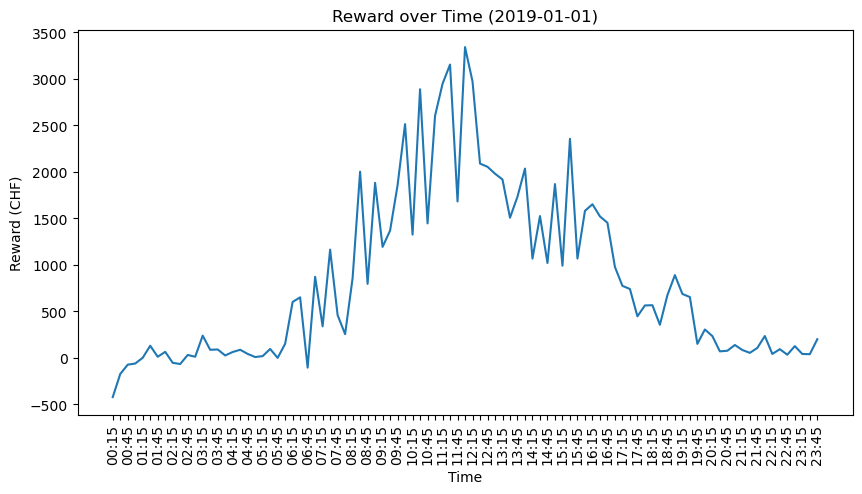

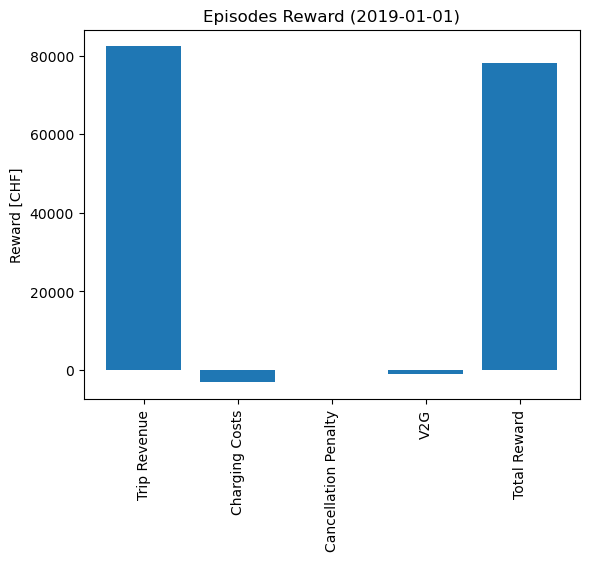

Total reward 2019-01-01:
78149.75351670088


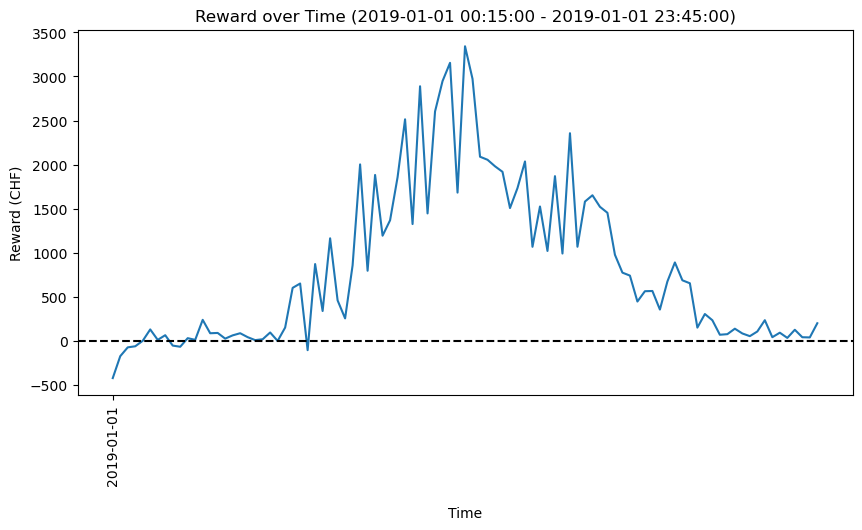

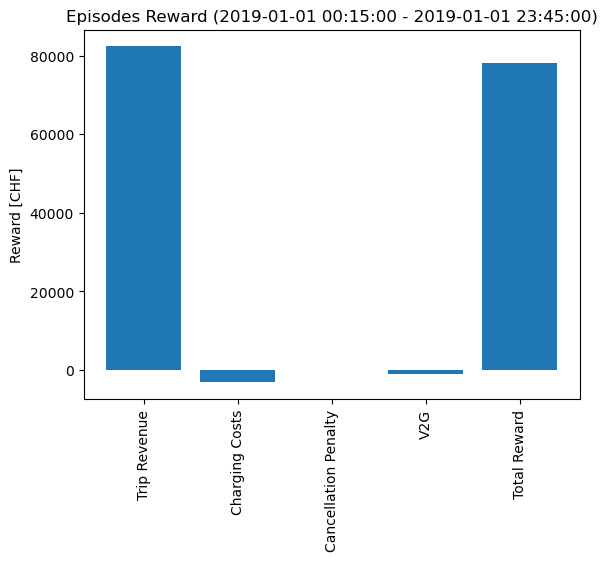

Total reward (2019-01-01 00:15:00 - 2019-01-01 23:45:00):
78149.75351670088


In [35]:
# datetime from the 01.01.2019 00:00
d = '2019-01-01 00:00'
firstJan19 =  datetime.strptime(d, '%Y-%m-%d %H:%M')

# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
days_from_1jan19 = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
    
    ####################################
    # Add the creation of the steps and km list
    
    # steps_next_booking_lst, dist_next_booking_lst = next_booking_all_vehicles(vehicles['vehicle_no'], firstJan19, reservations_week)
    vehicle_state_v2g = vehicle_stat_v2g_initialization(vehicles['vehicle_no'], vehicles['range'], vehicles['charge_power'], vehicles['battery_capacity'], firstJan19, reservations_week)
    ####################################
    
    # iteration for each day
    for day in range(98,676,96):
        
        # calculate number of timesteps since first day of simulation
        timesteps_since_start = count * 96
        
        # measure calculation time of episode
        start = time.time()
        
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        
        # reset environment at beginnning of simulation
        if count == 0:
            env = CarsharingEnv(stations,
                    vehicles,daily_data, reservations, electricity_price, timesteps_since_start, v2g_price,
                    cancellation_penalty = 100,
                    penalty_per_kwh = 0, # penalty for energy difference between start and end of the day
                    planned_bookings = False,
                    max_distance_car_assingment = 1000,
                    v2g_morning_time_period = [6.0, 6.5, 8.0], # Discharging vehicle event
                    v2g_evening_time_period = [18.0, 18.5, 20.0], # Discharging vehicle event
                    v2g_probability_discharging_event = 1.0,
                    v2g_noon_time_period = [12.0, 12.0, 14.0], # Charging vehicle event
                    v2g_probability_charging_event = 0.0,
                    v2g_penalty = 499,
                    # random_seed_number = 42
                    )
            s = env.reset()
            
        # beginn new day without reseting environemnt 
        else:
            env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price)
            
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            
            # Calculate current time
            minutes_steps = 15*counter + days_from_1jan19 * 1440 # add the number of days from 1jan19 
            cur_time = firstJan19 + timedelta(minutes=minutes_steps)
            
            # Calculate current step from 1Jan2019
            current_step_from_1jan2019 = counter + days_from_1jan19 * 96
            
            # Get the current electricity price
            current_electricity_price = electricity_price[current_step_from_1jan2019]
            
            # get your action 
            # act = your_v2g_strategy(s, nr_vehicles) # Original
            act, vehicle_state_v2g = your_v2g_strategy(s, nr_vehicles, vehicles['range'], vehicles['vehicle_no'], counter, vehicles, reservations_week, cur_time, vehicle_state_v2g, current_electricity_price)
            
            
             # Copy vehicle_state_v2g so that I can observe it in the last step
            v2g_info_pandas = vehicle_state_v2g

            # proceed one time step
            s, rew, done, _ = env.step(act)
            
            # print reward at time step
            #print("Reward in this step:", rew, " time: ", env.t)
            
            counter +=1
        
        # measure time needed for simulation of day
        end = time.time()
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        
        # plot summary statistics of episode (day)
        env.daily_summary_statistics()
        
        # plot summary statistic over full simulation period
        if count == nr_iterations - 1:
            env.episode_summary_statistics(nr_iterations)
        
        # count number of simulated days
        count += 1
        days_from_1jan19 +=1

In [36]:
# access reward lists after simulation
reward = env.reward_list
cancellation_penalty = env.reward_list_cancellation_penalty
charging_costs = env.reward_list_charging
trip_revenue = env.reward_list_trips
v2g_revenue_penalty = env.reward_list_v2g

In [37]:
# Sandbox

electricity_price
print(len(electricity_price))
first_elt = electricity_price[0]

print("First element of electricity_price : {}".format(first_elt))

96
First element of electricity_price : 0.05416017599999999


# Animation of simulaton

We can set the parameter ***plot_state_animation = True*** for getting an animation of the vehicels state at each timestep. Each pixel represents one vehicle of the car-sharing system. On a color scale blue-yellow, we can read the current SOC of each car. Grey vehicles are currently not available in the system (not yet implemented or other reasons). Red pixels refer to cars that are currently serving a booking.

In [38]:
env = CarsharingEnv(stations, vehicles, planned_bookings = False, plot_state_animation = True, v2g_penalty = 10000, penalty_per_kwh = 0)

TypeError: __init__() missing 4 required positional arguments: 'daily_data', 'reservations', 'electricity_price', and 'timesteps_since_start'

In [40]:
# simulate one day
nr_iterations = 1

# get number of vehicles
nr_vehicles = len(vehicles)

# maximal simulation length
if nr_iterations > 577:
    nr_iterations = 577
    
count = 0
# iterate over weeks (for loading weekly discrete data)
for week_nr in range(0, math.ceil(nr_iterations / 7)):
    # load discrete car-sharing table
    sql =  "SELECT * FROM discrete.discrete_weeks_{} ORDER BY vehicle_no".format(week_nr)
    data = pd.read_sql(sql, engine)
        
    # iteration for each day
    for day in range(98,676,96):
        
        # calculate number of timesteps since first day of simulation
        timesteps_since_start = count * 96
        
        # measure calculation time of episode
        start = time.time()
        
        # all requested days are simulated
        if count == nr_iterations:
            break
            
        # get date
        date_day = pd.to_datetime(data.columns[day-97]).date()
        date_day_string = date_day.strftime('%Y-%m-%d')
        
        # load reservations
        reservations = reservations_dict[date_day_string]
        
        # load electricity prices for charging
        electricity_price = charging_costs_dict[date_day_string]
        
        # load secondary energy prices for v2g
        v2g_price = v2g_price_dict[date_day_string]
    
        # select discrete data of day
        daily_data = data.iloc[:,day-97:day-1]
        
        # reset environment at beginnning of simulation
        if count == 0:
            s = env.reset(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price)
            
        # beginn new day without reseting environemnt 
        else:
            env.next_day(daily_data, reservations, electricity_price, timesteps_since_start, v2g_price)
            
        # simulate day in 15 min steps
        done = False
        counter = 0
        while not done:
            
            # get your action 
            act = your_v2g_strategy(s, nr_vehicles)

            # proceed one time step
            s, rew, done, _ = env.step(act)
            
            # print reward at time step
            print("Reward in this step:", rew, " time: ", env.t)
            
            counter +=1
        
        # measure time needed for simulation of day
        end = time.time()
        print("")
        print("Total Episode Time: ", end-start)
        print("")
        
        # plot summary statistics of episode (day)
        env.daily_summary_statistics()
        
        # count number of simulated days
        count += 1

TypeError: reset() takes 1 positional argument but 6 were given